# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from openai import OpenAI

# Read test set

In [2]:
df_test = pd.read_csv('sample_size_test.csv', converters={'accept': literal_eval})

In [3]:
df_test.head()

,doi,date,journal,title,text,_input_hash,_task_hash,_is_binary,tokens,spans,answer,_timestamp,_annotator_id,_session_id,Number_randomized
0,10.1001/jama.2021.23182,2022-01-11,JAMA,Effect of Anticoagulant Therapy for 6 Weeks vs...,IMPORTANCE: Among patients younger than 21 yea...,2091484765,691116617,False,"[{'text': 'IMPORTANCE', 'start': 0, 'end': 10,...","[{'start': 431, 'end': 434, 'text': '417', 'so...",accept,1698925285,2023-11-01_22-58-04,2023-11-01_22-58-04,417.0
1,10.1056/NEJMoa2029554,2021-01-28,N Engl J Med,Cryoballoon Ablation as Initial Therapy for At...,BACKGROUND: In patients with symptomatic parox...,262881337,1295783615,False,"[{'text': 'BACKGROUND', 'start': 0, 'end': 10,...","[{'start': 1413, 'end': 1416, 'text': '203', '...",accept,1699010454,2023-11-03_10-36-50,2023-11-03_10-36-50,203.0
2,10.1016/S0140-6736(21)02437-5,2022-01-29,Lancet,Abiraterone acetate and prednisolone with or w...,BACKGROUND: Men with high-risk non-metastatic ...,-1644274556,1956253037,False,"[{'text': 'BACKGROUND', 'start': 0, 'end': 10,...","[{'start': 2748, 'end': 2752, 'token_start': 5...",accept,1698586984,2023-10-29_14-16-14,2023-10-29_14-16-14,1974.0
3,10.1016/S0140-6736(21)02175-9,2022-02-05,Lancet,Trametinib versus standard of care in patients...,BACKGROUND: Low-grade serous carcinoma of the ...,-1329637756,1028618675,False,"[{'text': 'BACKGROUND', 'start': 0, 'end': 10,...","[{'start': 2132, 'end': 2135, 'token_start': 4...",accept,1698699754,2023-10-30_20-30-39,2023-10-30_20-30-39,260.0
4,10.1056/NEJMoa2206038,2022-07-21,N Engl J Med,Tirzepatide Once Weekly for the Treatment of O...,BACKGROUND: Obesity is a chronic disease that ...,-1468648928,980444276,False,"[{'text': 'BACKGROUND', 'start': 0, 'end': 10,...","[{'token_start': 63, 'token_end': 63, 'start':...",accept,1698673233,2023-10-30_14-14-09,2023-10-30_14-14-09,2539.0


# Predict the number of people who were randomized using GPT-4o

In [4]:
# Initialize the OpenAI client
client = OpenAI()

In [5]:
for index, row in df_test.iterrows():

    current_abstract = row["text"]

    # Let GPT-4o do the classification
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "You will be provided with the abstract of a randomized controlled clinical trial. Your task will be to extract the number of people who underwent randomization. If this number is not explicitly mentioned, you may use other numerical information (e.g. the number of total participants or adding up the number of patients in each arm) to infer that number. Please return only the number as a single integer. If no information is available, please return null.",
            },
            {"role": "user", "content": f"{current_abstract}"},
        ],
        temperature=0.2,
    )

    # Add the response to the dataframe
    df_test.loc[index, "GPT-4o_response_raw"] = response.choices[0].message.content

In [11]:
for index, row in df_test.iterrows():

    current_abstract = row["text"]

    # Let GPT-4o do the classification
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": "You will be provided with the abstract of a randomized controlled clinical trial. Your task will be to extract the number of people who underwent randomization. Please return only the number as a single integer. If this number is not explicitly mentioned, please return null.",
            },
            {"role": "user", "content": f"{current_abstract}"},
        ],
        temperature=0.2,
    )

    # Add the response to the dataframe
    df_test.loc[index, "GPT-4o_response_strict_raw"] = response.choices[0].message.content

In [12]:
df_test.to_csv("sample_size_gpt-4o_temp020.csv", index=False)

In [13]:
# Convert the response to a number
def extract_number(raw_prediction):
    if "null" in raw_prediction:
        return np.nan
    if "," in raw_prediction:
        raw_prediction = raw_prediction.replace(",", "")
    return int(raw_prediction)

df_test["GPT-4o_response"] = df_test["GPT-4o_response_raw"].apply(extract_number)
df_test["GPT-4o_response_strict"] = df_test["GPT-4o_response_strict_raw"].apply(extract_number)

# Evaluate the performance of the regular prompt

In [21]:
# Calculate how many predictions were made
print(
    f"Predicted {len(df_test[df_test['GPT-4o_response'].notnull()])} sample sizes."
)

# Calculate how many predictions were made in %
print(
    f"Predicted {len(df_test[df_test['GPT-4o_response'].notnull()]) / len(df_test) * 100:.1f}% of sample sizes."
)

Predicted 149 sample sizes.
Predicted 99.3% of sample sizes.


In [22]:
# Calculate the mean absolute percentage error for GPT-4o
df_test["GPT-4o_response_APE"] = (
    abs(df_test["GPT-4o_response"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)

print(
    f"Mean absolute percentage error for GPT-4o: {df_test['GPT-4o_response_APE'].mean():.1%}"
)

print(
    f"Median absolute percentage error for GPT-4o: {df_test['GPT-4o_response_APE'].median():.1%}"
)

Mean absolute percentage error for GPT-4o: 1.5%
Median absolute percentage error for GPT-4o: 0.0%


In [23]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["Number_randomized_prediction_GPT-4o_WITHIN_1_PERCENT"] = (
    df_test["GPT-4o_response_APE"] < 0.01
)

# Calculate the percentage of sample sizes that are within 10% of the ground truth
df_test["Number_randomized_prediction_GPT-4o_WITHIN_10_PERCENT"] = (
    df_test["GPT-4o_response_APE"] < 0.1
)

# Calculate the percentage of exact matches
df_test["Number_randomized_prediction_GPT-4o_EXACT"] = (
    df_test["GPT-4o_response"] == df_test["Number_randomized"]
)

number_within_1_percent = df_test[
    "Number_randomized_prediction_GPT-4o_WITHIN_1_PERCENT"
].sum()
number_within_10_percent = df_test[
    "Number_randomized_prediction_GPT-4o_WITHIN_10_PERCENT"
].sum()
number_exact = df_test["Number_randomized_prediction_GPT-4o_EXACT"].sum()
total_trials_with_gpt_4o = len(df_test[df_test["GPT-4o_response"].notnull()])

print(
    f"Percentage of extracted sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_gpt_4o:.1%}"
)
print(
    f"Percentage of extracted sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_gpt_4o:.1%}"
)
print(
    f"Percentage of exact matches: {number_exact/total_trials_with_gpt_4o:.1%}"
)

Percentage of extracted sample sizes within 1% of the ground truth: 90.6%
Percentage of extracted sample sizes within 10% of the ground truth: 96.6%
Percentage of exact matches: 88.6%


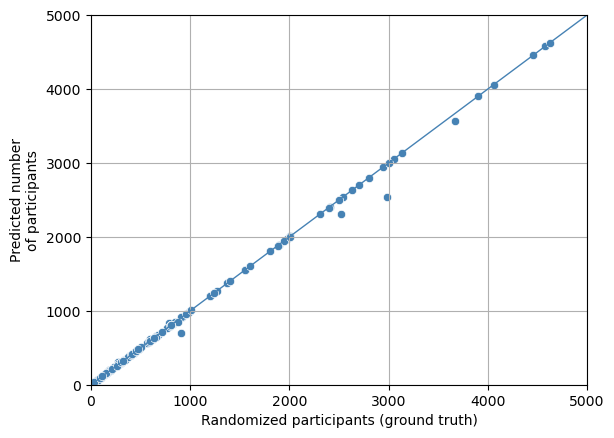

In [27]:
# Create a scatterplot for GPT-4o regular prompt
scatterplot_conditional_model = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GPT-4o_response",
    color="steelblue",
)

scatterplot_conditional_model.set_xlim(0, 5000)
scatterplot_conditional_model.set_ylim(0, 5000)

scatterplot_conditional_model.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_gpt4o_regular.png", dpi=300, bbox_inches="tight")

plt.show()

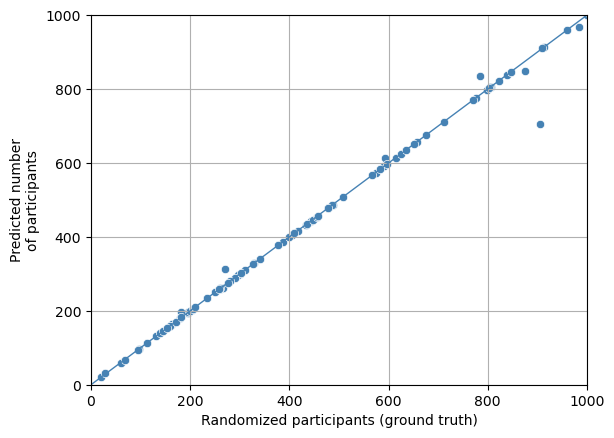

In [28]:
# Zoom in on the scatter plot
scatterplot_conditional_model_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GPT-4o_response",
    color="steelblue",
)

scatterplot_conditional_model_zoom.set_xlim(0, 1000)
scatterplot_conditional_model_zoom.set_ylim(0, 1000)

scatterplot_conditional_model_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model_zoom.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig(
    "plots/scatterplot_gpt4o_regular_zoom.png", dpi=300, bbox_inches="tight"
)

plt.show()

# Evaluate the performance of the strict prompt

In [24]:
# Calculate how many predictions were made
print(
    f"Predicted {len(df_test[df_test['GPT-4o_response_strict'].notnull()])} sample sizes."
)

# Calculate how many predictions were made in %
print(
    f"Predicted {len(df_test[df_test['GPT-4o_response_strict'].notnull()]) / len(df_test) * 100:.1f}% of sample sizes."
)

Predicted 142 sample sizes.
Predicted 94.7% of sample sizes.


In [25]:
# Calculate the mean absolute percentage error for GPT-4o strict
df_test["GPT-4o_response_strict_APE"] = (
    abs(df_test["GPT-4o_response_strict"] - df_test["Number_randomized"])
    / df_test["Number_randomized"]
)

print(
    f"Mean absolute percentage error for GPT-4o strict: {df_test['GPT-4o_response_strict_APE'].mean():.1%}"
)

print(
    f"Median absolute percentage error for GPT-4o strict: {df_test['GPT-4o_response_strict_APE'].median():.1%}"
)


Mean absolute percentage error for GPT-4o strict: 0.6%
Median absolute percentage error for GPT-4o strict: 0.0%


In [26]:
# Calculate the percentage of sample sizes that are within 1% of the ground truth
df_test["Number_randomized_prediction_GPT-4o_strict_WITHIN_1_PERCENT"] = (
    df_test["GPT-4o_response_strict_APE"] < 0.01
)
df_test["Number_randomized_prediction_GPT-4o_strict_WITHIN_10_PERCENT"] = (
    df_test["GPT-4o_response_strict_APE"] < 0.1
)
df_test["Number_randomized_prediction_GPT-4o_strict_EXACT"] = (
    df_test["GPT-4o_response_strict"] == df_test["Number_randomized"]
)

number_within_1_percent = df_test[
    "Number_randomized_prediction_GPT-4o_strict_WITHIN_1_PERCENT"
].sum()
number_within_10_percent = df_test[
    "Number_randomized_prediction_GPT-4o_strict_WITHIN_10_PERCENT"
].sum()
number_exact = df_test["Number_randomized_prediction_GPT-4o_strict_EXACT"].sum()
total_trials_with_gpt_4o_strict = len(df_test[df_test["GPT-4o_response_strict"].notnull()])
print(
    f"Percentage of extracted sample sizes within 1% of the ground truth: {number_within_1_percent/total_trials_with_gpt_4o_strict:.1%}"
)
print(
    f"Percentage of extracted sample sizes within 10% of the ground truth: {number_within_10_percent/total_trials_with_gpt_4o_strict:.1%}"
)
print(
    f"Percentage of exact matches: {number_exact/total_trials_with_gpt_4o_strict:.1%}"
)

Percentage of extracted sample sizes within 1% of the ground truth: 92.3%
Percentage of extracted sample sizes within 10% of the ground truth: 98.6%
Percentage of exact matches: 90.8%


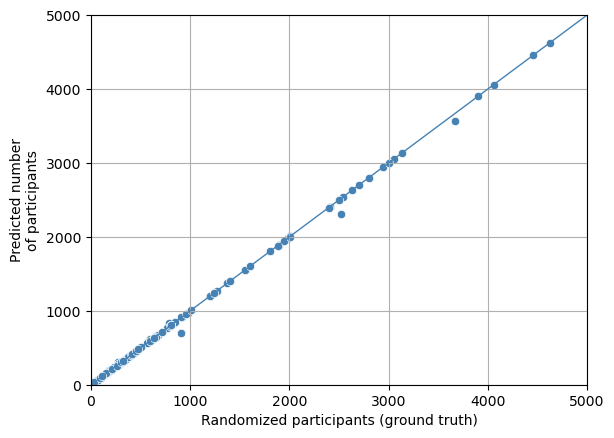

In [29]:
# Create a scatterplot for GPT-4o strict prompt
scatterplot_conditional_model_strict = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GPT-4o_response_strict",
    color="steelblue",
)

scatterplot_conditional_model_strict.set_xlim(0, 5000)
scatterplot_conditional_model_strict.set_ylim(0, 5000)

scatterplot_conditional_model_strict.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model_strict.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig("plots/scatterplot_gpt4o_strict.png", dpi=300, bbox_inches="tight")

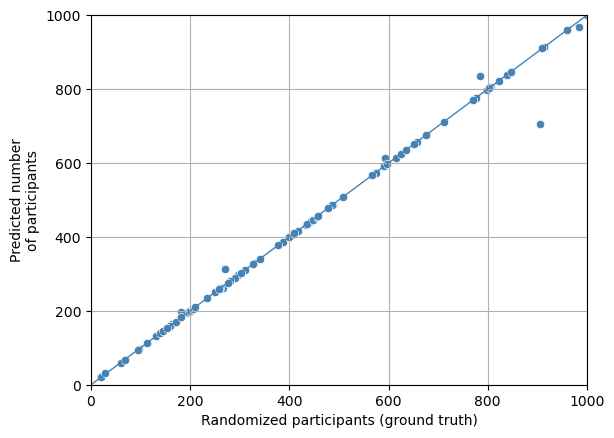

In [30]:
# Zoom in on the scatter plot
scatterplot_conditional_model_strict_zoom = sns.scatterplot(
    data=df_test,
    x="Number_randomized",
    y="GPT-4o_response_strict",
    color="steelblue",
)

scatterplot_conditional_model_strict_zoom.set_xlim(0, 1000)
scatterplot_conditional_model_strict_zoom.set_ylim(0, 1000)

scatterplot_conditional_model_strict_zoom.set_xlabel("Randomized participants (ground truth)")
scatterplot_conditional_model_strict_zoom.set_ylabel("Predicted number\nof participants")

# Add a diagonal line
xlim = plt.gca().get_xlim()
ylim = plt.gca().get_ylim()
plt.plot([xlim[0], xlim[1]], [ylim[0], ylim[1]], color="steelblue", linewidth=1)

plt.grid()

plt.savefig(
    "plots/scatterplot_gpt4o_strict_zoom.png", dpi=300, bbox_inches="tight"
)